# GLOBAL VARIABLE DEFINITION

To run the script, create the model class inside 

```
models/MODEL_NAME/model.py 
```

The module will be dynamically imported.

In [ ]:
# Set up the environment for a model training
MODEL_NAME = "BaseModel"
MODEL_PATH = "models/" + MODEL_NAME + "/"
MODEL_PATH_METRICS = MODEL_PATH + "metrics/"

# Set the data paths
METADATA_PATH = './data/metadata.json'
DATA_TRAIN_PATH = './data/train_sub'
DATA_VAL_PATH = './data/val_sub'
DATA_TEST_PATH = './data/val_sub' # Change this to the test data path if available

# SET THE CROSS VALIDATION PARAMETERS
CROSS_VAL = False # Set to True for cross-validation
if CROSS_VAL:
    NUM_SPLITS = 5 # Number of splits for cross-validation
    
# Set the training parameters
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VAL = 4
BATCH_SIZE_TEST = 4

NUM_EPOCHS = 10 # Number of epochs to train
PATIENCE = 5  # Number of epochs to wait for improvement

# Set the training parameters
BEST_MODEL_PATH = MODEL_PATH+'best_model.pth'
LAST_MODEL_PATH = MODEL_PATH+'last_model.pth'

In [2]:
# Check if MODEL_PATH folder exists
import os
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model directory '{MODEL_PATH}' does not exist. Please create it before running the script.")

if not os.path.exists(MODEL_PATH_METRICS):
    os.makedirs(MODEL_PATH_METRICS)
    print(f"Created directory '{MODEL_PATH_METRICS}' for metrics.")

# Imports

In [3]:
# Standard libraries
import os
import json
import importlib
from datetime import datetime

# Numerical and data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2

# Progress bar
from tqdm import tqdm

# PyTorch core
import torch
import torch.nn as nn
import torchvision

# PyTorch utilities
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter

# Machine learning and evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


In [4]:
# Build the module path dynamically
module_path = f"models.{MODEL_NAME}.model"

# Import the module
model_module = importlib.import_module(module_path)

# Data

## Labels

In [5]:
# Open metadata.json file
with open(METADATA_PATH) as f:
    metadata = json.load(f)


In [6]:
# Convert the metadata to a pandas DataFrame
metadata_df = pd.DataFrame(metadata)

# Transpose the DataFrame
metadata_df = metadata_df.transpose()

# Reset the index
metadata_df.reset_index(inplace=True)

# Rename the column index to filename
metadata_df.rename(columns={'index': 'filename'}, inplace=True)

# Convert labels to integers.
# REAL = 0
# FAKE = 1
metadata_df['label'] = metadata_df['label'].map({'REAL': 0, 'FAKE': 1})

In [7]:
metadata_df

,filename,label,split,original
0,owxbbpjpch.mp4,1,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,0,train,NaN
2,fzvpbrzssi.mp4,0,train,NaN
3,htorvhbcae.mp4,1,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4
...,...,...,...,...
1329,hectzcuzdv.mp4,1,train,vtunvalyji.mp4
1330,yxkbjxmtzr.mp4,1,train,sttnfyptum.mp4
1331,wkdnagybtb.mp4,1,train,jytrvwlewz.mp4
1332,fonrexmbzz.mp4,1,train,fufcmupzen.mp4


## Dataset creation

In [8]:
def extract_frames(video_path, num_frames=16):
    """Extract `num_frames` evenly spaced frames from a video."""
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = list(np.linspace(0, length-1, num_frames).astype(int))
    frames = []
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

In [9]:
class DeepfakeDataset(Dataset):
    def __init__(self, video_dir, labels_df, transform=None, num_frames=16):
        self.video_dir = video_dir
        
        # Remove all the labels that are not in the video_dir
        labels_df = labels_df[labels_df['filename'].isin(os.listdir(video_dir))]
        
        self.labels = labels_df
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        video_file = self.labels.iloc[idx]['filename']
        label = self.labels.iloc[idx]['label']  # 0: real, 1: fake
        video_path = os.path.join(self.video_dir, video_file)
        frames = extract_frames(video_path, num_frames=self.num_frames)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        # stack to (num_frames, C, H, W)
        frames = torch.stack(frames)
        return frames, torch.tensor(label, dtype=torch.long)
    
    def get_filenames(self):
        return self.labels['filename'].tolist()


In [10]:
data_transforms = model_module.get_data_transform()

# Create datasets for training & validation, download if necessary
training_set = DeepfakeDataset(DATA_TRAIN_PATH, metadata_df, transform=data_transforms)
validation_set = DeepfakeDataset(DATA_VAL_PATH, metadata_df, transform=data_transforms)
test_set = DeepfakeDataset(DATA_TEST_PATH, metadata_df, transform=data_transforms)

# Create data loaders for our datasets; shuffle for training, not for validation
# If CROSS_VAL is set to True, the loaders will be created in the cross-validation loop
if not CROSS_VAL:
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE_VAL, shuffle=False)

# Create data loader for test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)

# Class labels
classes = ('FAKE', 'REAL')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 7 instances
Validation set has 2 instances


# Visualization

In [11]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [12]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

REAL  REAL  REAL  REAL


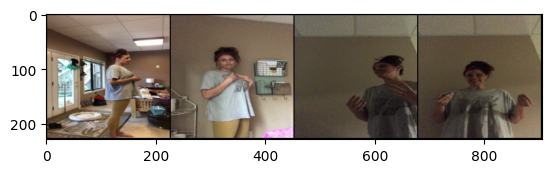

In [13]:
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid([images[0][0], images[1][0], images[2][0], images[3][0]], nrow=4)
matplotlib_imshow(img_grid)
print('  '.join(classes[labels[j]] for j in range(4)))

# Model

In [14]:
# Now can access things inside model_module
model = model_module.Model()

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print ("Using device:", device)

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    
model = model.to(device)

Using device: mps


# Loss function

In [15]:
loss_fn = model_module.get_loss_fn()

# Optimizer

In [16]:
# Optimizers specified in the torch.optim package
optimizer = model_module.get_optimizer(model.parameters())

# Save all the params

In [17]:
def serialize_value(value):
    """Helper to safely serialize values for JSON."""
    if isinstance(value, torch.Tensor):
        return value.tolist()
    elif isinstance(value, dict):
        return {k: serialize_value(v) for k, v in value.items()}
    elif isinstance(value, set):
        return list(value)
    else:
        return str(value)

def extract_params(obj):
    """Extracts public parameters from an object's __dict__, serializing them."""
    params = {}
    for key, value in getattr(obj, '__dict__', {}).items():
        if key.startswith('_'):
            continue  # skip private attributes
        params[key] = serialize_value(value)
    return params

def get_transform_info(transform):
    """Extracts transform name and parameters."""
    return {
        'name': transform.__class__.__name__,
        'params': extract_params(transform)
    }

# --- LOSS CONFIG ---
loss_config = extract_params(loss_fn)

# --- OPTIMIZER CONFIG ---
optimizer_params = serialize_value(optimizer.defaults)

# --- DATA TRANSFORMS CONFIG ---
if hasattr(data_transforms, 'transforms'):
    transform_list = [get_transform_info(t) for t in data_transforms.transforms]
else:
    transform_list = [get_transform_info(data_transforms)]

# --- FINAL MODEL INFO ---
model_info = {
    'model': MODEL_NAME,
    'optimizer': optimizer.__class__.__name__,
    'optimizer_params': optimizer_params,
    'loss_fn': loss_fn.__class__.__name__,
    'loss_fn_params': loss_config,
    'data_transforms': transform_list,
    'training_set_size': len(training_set),
    'validation_set_size': len(validation_set),
    'test_set_size': len(test_set),
    'batch_size_train': BATCH_SIZE_TRAIN,
    'batch_size_val': BATCH_SIZE_VAL,
    'batch_size_test': BATCH_SIZE_TEST,
    'num_epochs': NUM_EPOCHS,
    'patience': PATIENCE,
    'best_model_path': BEST_MODEL_PATH,
    'last_model_path': LAST_MODEL_PATH,
    'cross_val': CROSS_VAL,
    'num_splits': NUM_SPLITS if CROSS_VAL else None,
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# --- SAVE JSON ---
os.makedirs(MODEL_PATH, exist_ok=True)
with open(os.path.join(MODEL_PATH, 'model_info.json'), 'w') as f:
    json.dump(model_info, f, indent=4)

print("Model info saved successfully ✅")


Model info saved successfully ✅


# Training loop

In [18]:
# Function to train the model for one epoch
def train_epoch(model, loader, criterion, optimizer, writer, epoch):
    """
    Train the model for one epoch.

    Args:
        model: The model to train.
        loader: DataLoader for the training data.
        criterion: Loss function.
        optimizer: Optimizer for updating model weights.
        writer: TensorBoard SummaryWriter for logging.
        epoch: Current epoch number.

    Returns:
        epoch_loss: Average loss for the epoch.
        epoch_acc: Accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc=f"Training Epoch {epoch+1}"):
        # Move inputs and labels to the device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_acc, epoch)

    return epoch_loss, epoch_acc

# Function to evaluate the model for one epoch
def eval_epoch(model, loader, criterion, writer, epoch):
    """
    Evaluate the model for one epoch.

    Args:
        model: The model to evaluate.
        loader: DataLoader for the validation data.
        criterion: Loss function.
        writer: TensorBoard SummaryWriter for logging.
        epoch: Current epoch number.

    Returns:
        epoch_loss: Average loss for the epoch.
        epoch_acc: Accuracy for the epoch.
    """
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in tqdm(loader, desc=f"Validation Epoch {epoch+1}"):
            # Move inputs and labels to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation Loss', epoch_loss, epoch)
    writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

    return epoch_loss, epoch_acc


# Per-epoch activity

In [19]:
# Check if the model already exists
if os.path.exists(BEST_MODEL_PATH):
    # Ask the user if they want to overwrite the existing model
    user_input = input(f"Model already exists at {BEST_MODEL_PATH}. Do you want to overwrite it? (y/n): ")
    if user_input.lower() == 'y':
        pass
    else:
        raise ValueError(f"Model already exists at {BEST_MODEL_PATH}. Please remove it before training.")

In [20]:
def per_epoch_activity(num_epochs, training_loader, validation_loader, model, loss_fn, optimizer, writer, patience=5):
    """
    Train and evaluate the model for a specified number of epochs.
    
    Args:
        num_epochs: Number of epochs to train.
        training_loader: DataLoader for the training data.
        validation_loader: DataLoader for the validation data.
        model: The model to train.
        loss_fn: Loss function.
        optimizer: Optimizer for updating model weights.
        writer: TensorBoard SummaryWriter for logging.
        patience: Number of epochs to wait for improvement before stopping.
    """
    best_acc = 0.0 # Best validation accuracy
    no_improve_epochs = 0  # Counter for epochs without improvement
    
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_epoch(model, training_loader, loss_fn, optimizer, writer, epoch)
        val_loss, val_acc = eval_epoch(model, validation_loader, loss_fn, writer, epoch)
        print(f"Epoch {epoch+1}/{num_epochs}", 
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}", 
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            no_improve_epochs = 0  # Reset counter if validation accuracy improves
        else:
            no_improve_epochs += 1

        # Early stopping
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # Save the model last epoch
        torch.save(model.state_dict(), LAST_MODEL_PATH)

In [21]:

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(MODEL_PATH+'/runs/deepfake_logs_{}'.format(timestamp))

if CROSS_VAL:
    # K-Fold Cross Validation
    splits = NUM_SPLITS
    kfold = KFold(n_splits=splits, shuffle=True)
    dataset = ConcatDataset([training_set, validation_set])

    for fold, (train_ids, test_ids) in tqdm(enumerate(kfold.split(dataset))):

        print(f'Fold {fold+1}/{splits}')
        training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE_VAL, shuffle=False)
            
        per_epoch_activity(NUM_EPOCHS, training_loader, validation_loader, model, loss_fn, optimizer, writer, patience=PATIENCE)
else:
    # No K-Fold Cross Validation
    per_epoch_activity(NUM_EPOCHS, training_loader, validation_loader, model, loss_fn, optimizer, writer, patience=PATIENCE)
    
# Close the TensorBoard writer
writer.close()

Validation Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Epoch 1/10 Train Loss: 1.2674, Train Acc: 0.1429 Val Loss: 0.5182, Val Acc: 1.0000


 20%|██        | 2/10 [00:25<01:40, 12.56s/it]

Epoch 2/10 Train Loss: 0.3247, Train Acc: 1.0000 Val Loss: 0.0832, Val Acc: 1.0000


 30%|███       | 3/10 [00:37<01:27, 12.53s/it]

Epoch 3/10 Train Loss: 0.0369, Train Acc: 1.0000 Val Loss: 0.0138, Val Acc: 1.0000


 40%|████      | 4/10 [00:50<01:14, 12.44s/it]

Epoch 4/10 Train Loss: 0.0037, Train Acc: 1.0000 Val Loss: 0.0029, Val Acc: 1.0000


 50%|█████     | 5/10 [01:02<01:01, 12.33s/it]

Epoch 5/10 Train Loss: 0.0006, Train Acc: 1.0000 Val Loss: 0.0008, Val Acc: 1.0000


 50%|█████     | 5/10 [01:14<01:14, 14.86s/it]

Epoch 6/10 Train Loss: 0.0002, Train Acc: 1.0000 Val Loss: 0.0002, Val Acc: 1.0000
Early stopping triggered after 6 epochs.


# Open saved model

In [22]:
saved_model = model_module.Model()
saved_model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

# Inference

In [23]:
# Example inference on a single video
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

video_path = 'data/val/acagallncj.mp4'
frames = extract_frames(video_path, num_frames=16)
inputs = data_transforms(frames[0]).unsqueeze(0)  # For demonstration, use first frame
inputs = inputs.to(device)
with torch.no_grad():
    output = model(inputs.unsqueeze(1))  # shape (1, num_frames, C, H, W)
    pred = output.argmax(dim=1).item()
print("Predicted label: ", 'Fake' if pred == 1 else 'Real')
print("Real label: ", 'Fake' if metadata_df[metadata_df['filename'] == 'acagallncj.mp4']['label'].values[0]== 1 else 'Real')

Predicted label:  Fake
Real label:  Fake


# Test

In [24]:
# Run test loop on validation set
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec  = recall_score(all_labels, all_preds, average='binary')
f1   = f1_score(all_labels, all_preds, average='binary')

class_report = classification_report(all_labels, all_preds, labels=classes, target_names=classes)

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use 

In [25]:
print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}\n")
print("Classification Report:\n", class_report)


Test Accuracy : 1.0000
Precision     : 1.0000
Recall        : 1.0000
F1 Score      : 1.0000

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00         0
        REAL       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



In [26]:
# Save results to CSV
results_df = pd.DataFrame({
    'filename': test_set.get_filenames(),
    'label': all_labels,
    'predicted_label': all_preds
})
results_df['correct'] = results_df['label'] == results_df['predicted_label']
results_df.to_csv(MODEL_PATH_METRICS+'results.csv', index=False)

In [27]:
# Save Acc, Precision, Recall, F1 to CSV
metrics_df = pd.DataFrame({
    'accuracy': [acc],
    'precision': [prec],
    'recall': [rec],
    'f1_score': [f1]
})
metrics_df.to_csv(MODEL_PATH_METRICS+'metrics.csv', index=False)

# Save classification report to txt file
with open(MODEL_PATH_METRICS+'classification_report.txt', 'w') as f:
    f.write(class_report)


/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


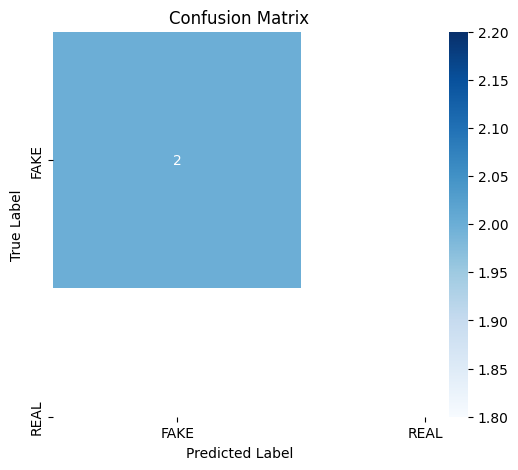

In [28]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.savefig(MODEL_PATH_METRICS+'confusion_matrix.png')
plt.show()